# **Buffer Manager Structure**


- PostgreSQL 버퍼 관리자는 다음 섹션에서 설명하는 버퍼 테이블, 버퍼 설명자 및 버퍼 풀로 구성
- 버퍼 풀 레이어에는 테이블, 인덱스 등의 데이터 파일 페이지와 자유 공간 맵 , 가시성 맵이 저장
- 버퍼 풀은 각 슬롯이 데이터 파일의 한 페이지를 저장하는 배열
  - 버퍼 풀 배열의 인덱스를 buffer_id 라고 함

# **Buffer Tag**

- PostgreSQL에서는 모든 데이터 파일의 각 페이지에 고유한 태그, 즉 버퍼 태그를 할당할 수 있음.
- 버퍼 관리자가 요청을 받으면 PostgreSQL은 원하는 페이지의 buffer_tag를 사용.

**buffer_tag 다섯 가지 값**

- specOid: 대상 페이지가 포함된 릴레이션이 속한 테이블스페이스의 OID.

- dbOid: 대상 페이지가 포함된 관계가 속한 데이터베이스의 OID.

- relNumber: 대상 페이지가 포함된 관계 파일의 번호.

- blockNum: 관계에 있는 대상 페이지의 블록 번호.

- forkNum: 페이지가 속한 관계의 포크 번호.
  - 테이블의 포크 번호, 자유 공간 맵, 가시성 맵은 각각 0, 1, 2로 정의.



```
 buffer_tag
/*
 * Buffer tag identifies which disk block the buffer contains.
 *
 * Note: the BufferTag data must be sufficient to determine where to write the
 * block, without reference to pg_class or pg_tablespace entries.  It's
 * possible that the backend flushing the buffer doesn't even believe the
 * relation is visible yet (its xact may have started before the xact that
 * created the rel).  The storage manager must be able to cope anyway.
 *
 * Note: if there's any pad bytes in the struct, InitBufferTag will have
 * to be fixed to zero them, since this struct is used as a hash key.
 */
typedef struct buftag
{
	Oid			spcOid;			/* tablespace oid */
	Oid			dbOid;			/* database oid */
	RelFileNumber relNumber;	/* relation file number */
	ForkNumber	forkNum;		/* fork number */
	BlockNumber blockNum;		/* blknum relative to begin of reln */
} BufferTag;
```

- 예를 들어 buffer_tag '{16821, 16384, 37721, 0, 7}'은 OID와 포크 번호가 각각 37721과 0인 테이블의 7번째 블록에 있는 페이지를 식별.
  - 해당 테이블은 OID가 16821인 테이블스페이스 아래 OID가 16384인 데이터베이스에 포함되어 있음.

- 마찬가지로 buffer_tag '{16821, 16384, 37721, 1, 3}'은 OID와 포크 번호가 각각 37721과 1인 자유 공간 맵의 세 번째 블록에 있는 페이지를 식별.

# **How a Backend Process Reads Pages**

- 백엔드 프로세스가 버퍼 관리자에서 페이지를 읽는 방법을 설명

**How a backend reads a page from the buffer manager.**

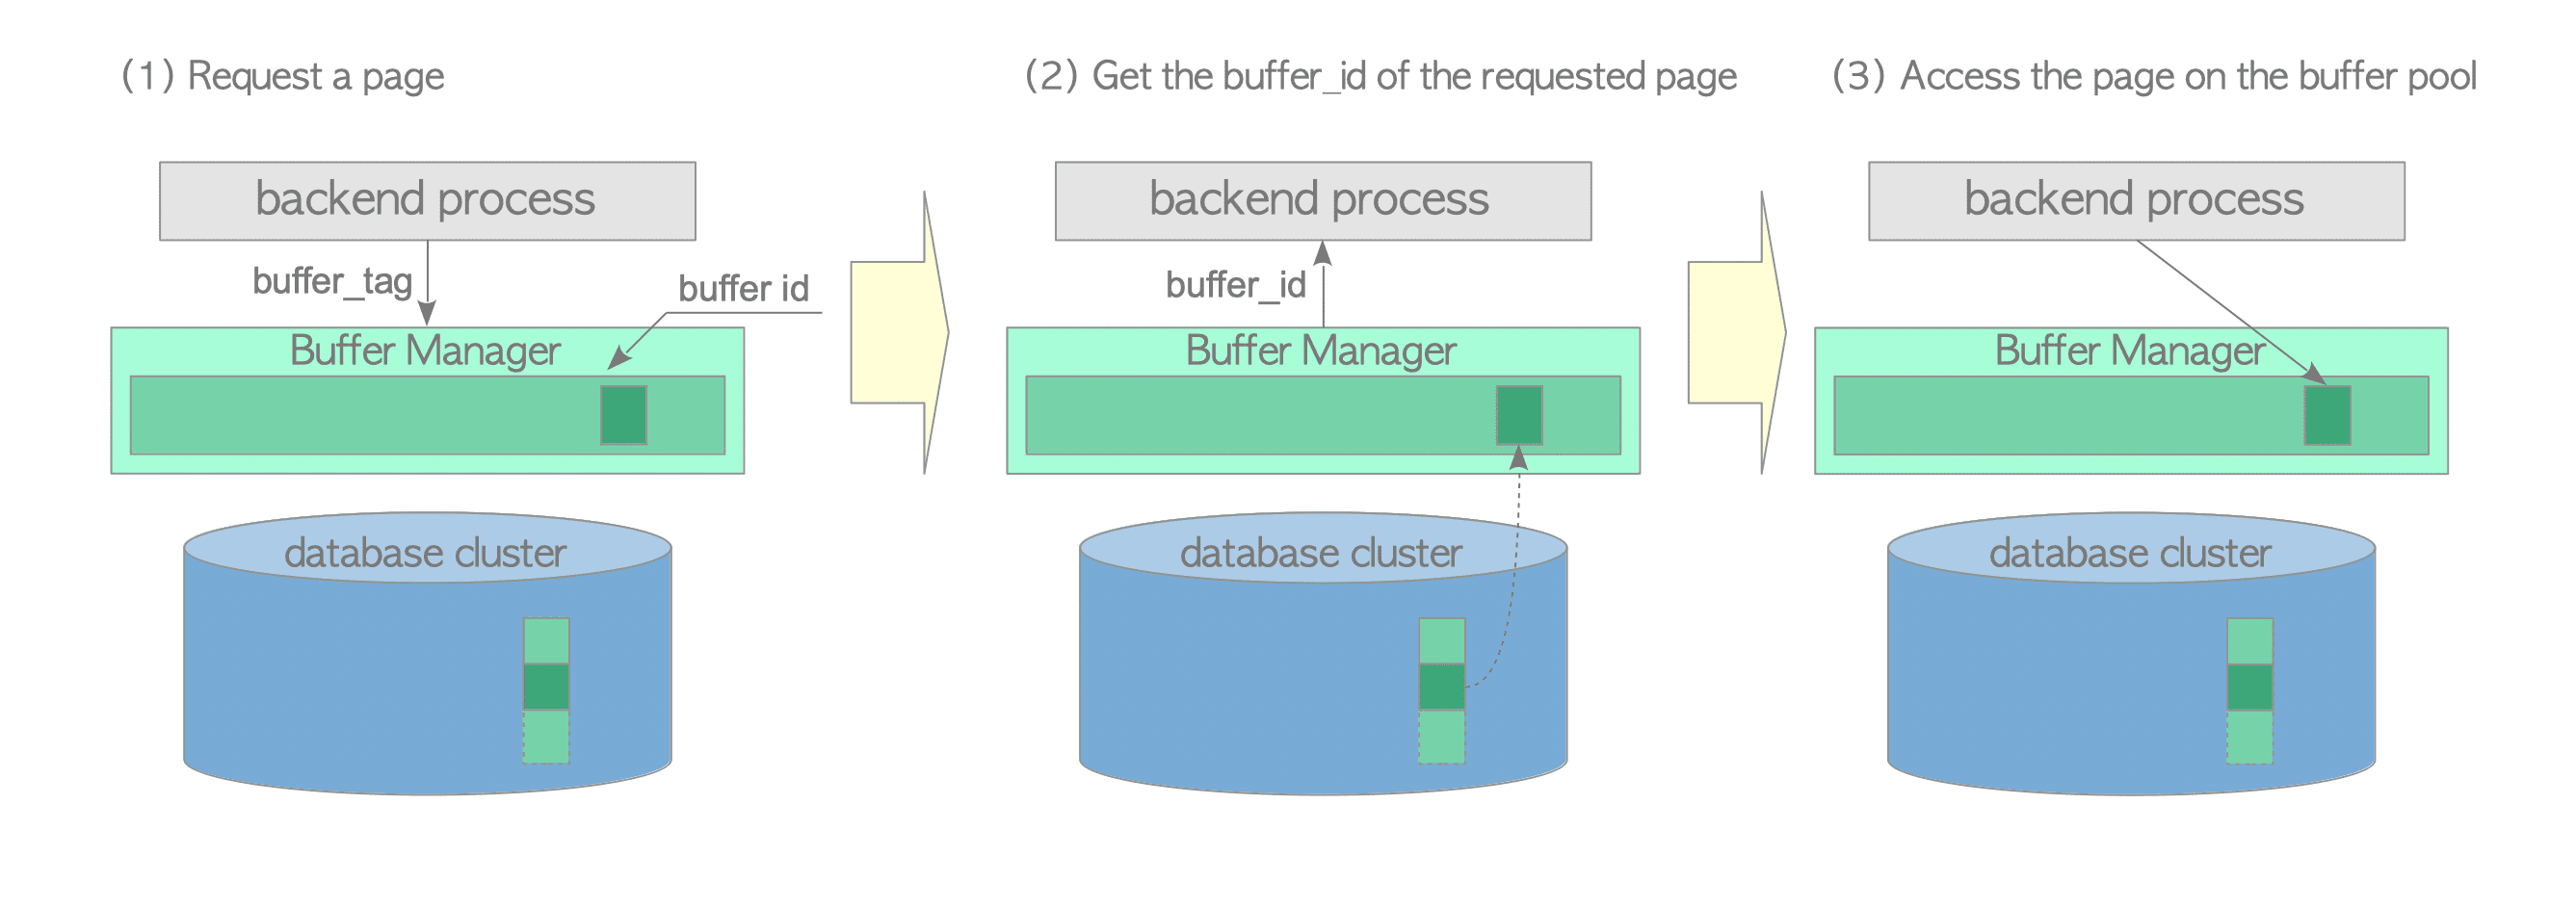

1. 백엔드 프로세스는 테이블이나 인덱스 페이지를 읽을 때 해당 페이지의 buffer_tag가 포함된 요청을 버퍼 관리자에게 보냄.

2. 버퍼 관리자는 요청된 페이지가 저장된 슬롯의 buffer_ID를 반환
  - 요청된 페이지가 버퍼 풀에 저장되지 않은 경우 버퍼 관리자는 영구 저장소에서 버퍼 풀 슬롯 중 하나로 페이지를 로드한 다음 슬롯의 buffer_ID를 반환.

3. 백엔드 프로세스가 buffer_ID의 슬롯에 액세스(원하는 페이지를 읽기 위해).

- 백엔드 프로세스가 버퍼 풀의 페이지를 수정하는 경우(예: 튜플 삽입) 아직 스토리지에 플러시되지 않은 수정된 페이지를 더티 페이지 라고 함

# **Page Replacement Algorithm**

- 모든 버퍼 풀 슬롯이 사용되고 요청한 페이지가 저장되지 않은 경우 버퍼 관리자는 요청한 페이지로 교체할 버퍼 풀에서 한 페이지를 선택해야 함
  - 일반적으로 컴퓨터 과학 분야에서는 페이지 선택 알고리즘을 페이지 교체 알고리즘 이라고 하며, 선택된 페이지를 피해자 페이지 라고 함
  
- 페이지 교체 알고리즘에 대한 연구는 컴퓨터 과학이 등장한 이래로 계속 진행
- 많은 대체 알고리즘이 제안되었으며 PostgreSQL은 버전 8.1부터 시계 스윕 알고리즘을 사용.
- 클록 스윕은 이전 버전에서 사용된 LRU 알고리즘보다 더 간단하고 효율적

# **Flushing Dirty Pages**

- 더티 페이지는 결국 저장소로 플러시되어야 함.
- 그러나 버퍼 관리자가 이 작업을 수행하려면 도움이 필요.
- PostgreSQL에서는 체크포인터 와 백그라운드 라이터라는 두 가지 백그라운드 프로세스가 이 작업을 담당.

**Direct I/O**
- PostgreSQL 버전 15 이하에서는 이미 논의되었지만 직접 I/O를 지원하지 않음. .

- 버전 16에는 debug-io-direct 옵션이 추가.
- 이 옵션은 개발자가 PostgreSQL에서 직접 I/O 사용을 개선하기 위한 것.
- 개발이 잘 진행된다면 가까운 시일 내에 Direct I/O도 공식적으로 지원될 예정